# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

The project is about analysing and predicting churn in users of the website Sparkify, where the churn i.e. cancellation of subscription is predicted using information about the user such as gender, number of songs listened to, number of artists listened to, number of likes, and dislikes, etc. 

This problem is used in businesses that provide subscription based services to users, and this prediction model can help them understand their users better to make changes to their product and recommendations to retain more users. 

The problem statement is to predict user's churn based on other features provided in the dataset. 
The expected solution can be any non-linear machine learning model such as logistic regression, naive bayes algorithm, non-linear deep learning models like multi-layer perceptron, etc. 

Metrics:

We will be using the F1 score and accuracy for evaluating the performance of the prediction model. Accuracy is the fraction of predictions the prediction model got right. 

F1 score can be defined as the Harmonic mean of precision and recall. Precision can be defined as the number of true positives divided by the total of true positives and false positives whereas recall can be defined as true positives divided by the total of true positives and false negatives.

In [1]:
# import libraries
#pandas for dataframe manipulation 
import pandas as pd 
#numpy for numerical processing 
import numpy as np
#matplotlib for plotting 
import matplotlib.pyplot as plt
%matplotlib inline 
#seaborn for visualization 
import seaborn as sns 
#to use spark functions in Python 
import pyspark 
#sys and time for house keeping 
import sys 
import time 


In [2]:
sns.set()

In [3]:
#creating a sparksession in which we shall use spark functions and perform data analysis 
from pyspark.sql import SparkSession

In [4]:
#name of the session object is "spark" with appName as "Capstone Project: Sparkify "
spark = SparkSession \
    .builder \
    .appName("Capstone Project: Sparkify ") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
#using read.json function with the given file name we read the data 
df = spark.read.json("mini_sparkify_event_data.json")

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [6]:
#describe function to understand the columns and their data type 
df.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

In [7]:
#the top 10 rows of the data are displayed using head function 
df.head(10)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [8]:
#the number of rows in the data are known using count 
df.count()

286500

In [9]:
#these functions can be used for pandas dataframe ibject and not spark dataframe object 
#df.info()
#df.tail()

#df.shape()
#df.size()

#df.isnull()
#df.isna()

#df.duplicated()


In [10]:
df.sample(0.2)

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [11]:
#the names of the columns in the dataframe 
df.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId']

In [12]:
#the data type of data in each column 
df.dtypes

[('artist', 'string'),
 ('auth', 'string'),
 ('firstName', 'string'),
 ('gender', 'string'),
 ('itemInSession', 'bigint'),
 ('lastName', 'string'),
 ('length', 'double'),
 ('level', 'string'),
 ('location', 'string'),
 ('method', 'string'),
 ('page', 'string'),
 ('registration', 'bigint'),
 ('sessionId', 'bigint'),
 ('song', 'string'),
 ('status', 'bigint'),
 ('ts', 'bigint'),
 ('userAgent', 'string'),
 ('userId', 'string')]

In [13]:
#drop the rows with NAN as userId or sessionId
df = df.dropna(how = 'any', subset = ["userId", "sessionId"])

In [14]:
#defining churn using the page column 
#visited the page of cancellation 

#df["page"].unique()

In [15]:
#count of the users who cancelled the subscription 
df.where(df.page=="Cancellation Confirmation").count()
# 52 

52

In [16]:
#import all pyspark sql functions 
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg
from pyspark.sql.functions import sum as Fsum

In [17]:
#import sql data types 
from pyspark.sql.types import StringType, IntegerType

In [18]:
#create a column for the users with cancellation/not cancellation confirmation 
#as churn
churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())


In [19]:
#df["churn"] = df["page"].apply(churn_event)

In [20]:
#df = spark.createDataFrame(df)

In [21]:
df = df.withColumn("churn", churn_event(df.page))

In [22]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', churn=0)

In [23]:
#a lot of other exploratory analysis can be done 

In [24]:
from pyspark.sql.window import Window

windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
df = df.withColumn("churn", Fsum("churn").over(windowval))

In [25]:
#create a dataframe with userid, churn and level columns grouping by level and churn and adding the count to the count column 
df_level = df.select(['userId', 'churn', 'level']).dropDuplicates().groupBy('level','churn').count()

#create a dataframe with sessionid, churn and nextsong columns grouping by sessionid and churn and adding the count to the count column 
df_songs = df.filter(df.page == "NextSong").dropDuplicates().groupBy('sessionId','churn').count()
df_songs = df_songs.groupby('churn').agg({"count":"avg"})

#create a dataframe with userid, churn and artists columns grouping by userid and churn and adding the count to the count column 
df_artists = df.select("artist", "userId", "churn").dropDuplicates().groupby("userId", "churn").count()
df_artists = df_artists.groupby('churn').agg({"count":"avg"})

df_count = df.select(['userId', 'churn']).dropDuplicates().groupBy('churn').count()

In [26]:
#converting spark dataframe to pnadas dataframe 
df_plot1 = df_level.toPandas()
df_plot2 = df_songs.toPandas()
df_plot3 = df_artists.toPandas()

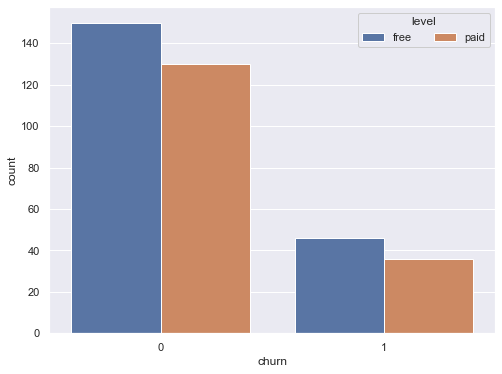

In [27]:
#plot churn by level
plt.figure(figsize = [8,6])
ax = sns.barplot(data = df_plot1, x = 'churn', y='count', hue = 'level')
ax.legend(loc = 1, ncol = 2, framealpha =1, title = 'level')

Text(0.5, 1.0, 'Average number of Songs')

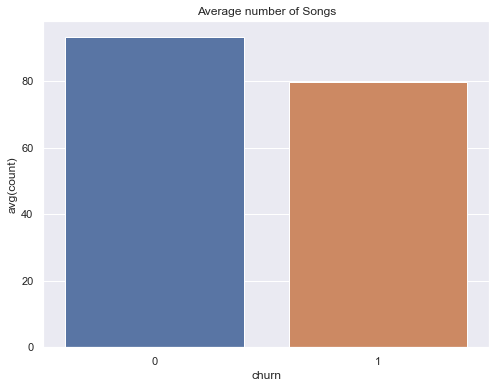

In [28]:
#plot churn by number of songs
plt.figure(figsize = [8,6])
ax = sns.barplot(data = df_plot2, x = 'churn', y='avg(count)')
plt.title("Average number of Songs")

Text(0.5, 1.0, 'Number of Artists Listened to')

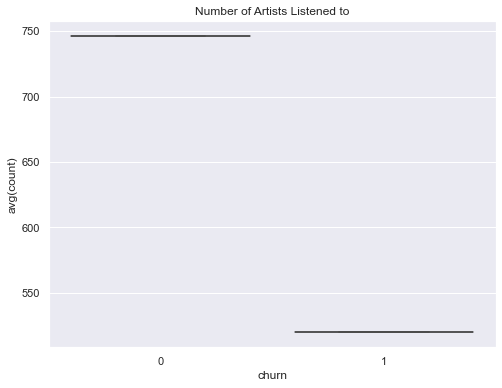

In [29]:
#plot churn by number of artists 
plt.figure(figsize = [8,6])
ax = sns.boxplot(data = df_plot3, x = 'churn', y='avg(count)')
plt.title("Number of Artists Listened to")

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [30]:
#importing more spark functions for further processing 
from pyspark.sql.window import Window
from pyspark.sql import Row
from pyspark.sql.functions import *

**Data Pre-processing**

In [31]:
#feature 1 = ts
df2 = df.select(['userId', 'level', 'ts']).dropDuplicates().sort('userId')
w = Window.partitionBy("userId").orderBy(desc("ts"))
df2 = df2.withColumn("Rank", dense_rank().over(w))
df2.show()

+------+-----+-------------+----+
|userId|level|           ts|Rank|
+------+-----+-------------+----+
|      | paid|1543622241000|   1|
|      | paid|1543622240000|   2|
|      | paid|1543622135000|   3|
|      | free|1543620936000|   4|
|      | paid|1543619531000|   5|
|      | paid|1543619530000|   6|
|      | paid|1543619485000|   7|
|      | paid|1543619484000|   8|
|      | paid|1543619475000|   9|
|      | paid|1543619432000|  10|
|      | paid|1543616907000|  11|
|      | paid|1543616906000|  12|
|      | free|1543616744000|  13|
|      | free|1543616699000|  14|
|      | paid|1543615206000|  15|
|      | paid|1543615205000|  16|
|      | free|1543612266000|  17|
|      | free|1543612265000|  18|
|      | free|1543612237000|  19|
|      | paid|1543608666000|  20|
+------+-----+-------------+----+
only showing top 20 rows



In [32]:
#feature 2 = level i.e. whether a paid user or user without subcription 
level1 = df2.filter(df2.Rank == 1).drop(df2.Rank)
level1 = level1.drop('ts')
level1 = level1.withColumn('level1', when(col('level') == 'paid', 1).otherwise(0))
level1.show()

+------+-----+------+
|userId|level|level1|
+------+-----+------+
|      | paid|     1|
|    10| paid|     1|
|   100| paid|     1|
|100001| free|     0|
|100002| paid|     1|
|100003| free|     0|
|100004| paid|     1|
|100005| free|     0|
|100006| free|     0|
|100007| paid|     1|
|100008| free|     0|
|100009| free|     0|
|100010| free|     0|
|100011| free|     0|
|100012| free|     0|
|100013| paid|     1|
|100014| paid|     1|
|100015| paid|     1|
|100016| free|     0|
|100017| free|     0|
+------+-----+------+
only showing top 20 rows



In [33]:
#feature 3 = number of songs each user has listened 
songs = df.filter(df.page == "NextSong").groupBy('userId','sessionId').count()
df.filter(df.page == "NextSong").groupBy('userId','sessionId').count().show()
songs = songs.groupby('userId').agg({"count":"avg"})
songs = songs.withColumnRenamed("avg(count)", "songs")
songs.show()

+------+---------+-----+
|userId|sessionId|count|
+------+---------+-----+
|    92|      358|   57|
|    42|      433|   16|
|   101|      635|  708|
|   120|      627|  236|
|   140|      798|    3|
|   122|      691|    6|
|    29|     1030|   13|
|     8|     1200|   11|
|    96|     1653|  133|
|   153|     1794|   62|
|    97|     2019|   70|
|    35|     2270|   10|
|   110|     1776|   18|
|300011|       60|   27|
|   137|      136|    6|
|    40|      484|   61|
|    35|      544|   13|
|    24|      620|    5|
|    47|       46|    3|
|    85|     1098|   73|
+------+---------+-----+
only showing top 20 rows

+------+------------------+
|userId|             songs|
+------+------------------+
|100010|39.285714285714285|
|200002|              64.5|
|   125|               8.0|
|    51|             211.1|
|   124|145.67857142857142|
|     7|21.428571428571427|
|    54| 81.17142857142858|
|    15|136.71428571428572|
|   155|136.66666666666666|
|100014|42.833333333333336|
|   132|  

In [34]:
#feature 4 = number of times thumbs up event was used by each user 
thumbsup = df.select(["userId", "page"])
thumbsup_event = udf(lambda x: 1 if x == "Thumbs Up" else 0, IntegerType())
thumbsup = thumbsup.withColumn("Thumbs Up", thumbsup_event("page"))
thumbsup = thumbsup.groupby('userId').sum("Thumbs Up")
thumbsup = thumbsup.withColumnRenamed("sum(Thumbs Up)", "thumbs_up")
thumbsup.show()

+------+---------+
|userId|thumbs_up|
+------+---------+
|100010|       17|
|200002|       21|
|   125|        0|
|    51|      100|
|   124|      171|
|     7|        7|
|    54|      163|
|    15|       81|
|   155|       58|
|   132|       96|
|   154|       11|
|100014|       17|
|   101|       86|
|    11|       40|
|   138|       95|
|300017|      303|
|    29|      154|
|    69|       72|
|100021|       11|
|    42|      166|
+------+---------+
only showing top 20 rows



In [35]:
#feature 5 = number of times thumbs down event was used by each user 
thumbsdown = df.select(["userId", "page"])
thumbsdown_event = udf(lambda x: 1 if x == "Thumbs Down" else 0, IntegerType())
thumbsdown = thumbsdown.withColumn("Thumbs Down", thumbsdown_event("page"))
thumbsdown = thumbsdown.groupby('userId').sum("Thumbs Down")
thumbsdown = thumbsdown.withColumnRenamed("sum(Thumbs Down)", "thumbs_down")
thumbsdown.show()

+------+-----------+
|userId|thumbs_down|
+------+-----------+
|100010|          5|
|200002|          6|
|   125|          0|
|    51|         21|
|   124|         41|
|     7|          1|
|    54|         29|
|    15|         14|
|   155|          3|
|   132|         17|
|   154|          0|
|100014|          3|
|   101|         16|
|    11|          9|
|   138|         24|
|300017|         28|
|    29|         22|
|    69|          9|
|100021|          5|
|    42|         25|
+------+-----------+
only showing top 20 rows



In [36]:
#feature 6 = number of times roll advert event was used by each user 
ads = df.select(["userId", "page"])
ads_event = udf(lambda x: 1 if x == "Roll Advert" else 0, IntegerType())
ads = ads.withColumn("ads", ads_event("page"))
ads = ads.groupby('userId').sum("ads")
ads = ads.withColumnRenamed("sum(ads)", "ads")
ads.show()

+------+---+
|userId|ads|
+------+---+
|100010| 52|
|200002|  7|
|   125|  1|
|    51|  0|
|   124|  4|
|     7| 16|
|    54| 47|
|    15|  1|
|   155|  8|
|   132|  2|
|   154| 10|
|100014|  2|
|   101|  8|
|    11| 39|
|   138| 17|
|300017| 11|
|    29| 22|
|    69|  3|
|100021| 30|
|    42| 10|
+------+---+
only showing top 20 rows



In [37]:
#feature 7 = count of the different artists each user has listened to 
artists = df.select("userId", "artist").dropDuplicates().groupby("userId").count()
artists = artists.withColumnRenamed("count", "artists")
artists.show()

+------+-------+
|userId|artists|
+------+-------+
|100010|    253|
|200002|    340|
|   125|      9|
|    51|   1386|
|   124|   2233|
|     7|    143|
|    15|   1303|
|    54|   1745|
|   155|    644|
|   132|   1300|
|   154|     79|
|100014|    234|
|   101|   1242|
|    11|    535|
|   138|   1333|
|300017|   2071|
|    29|   1805|
|    69|    866|
|100021|    208|
|    42|   2074|
+------+-------+
only showing top 20 rows



In [38]:
#dependent variable = whether the user churned or not 
label = df.select("userId", "churn").dropDuplicates().groupby("userId", "churn").count()
label = label.drop('count')
label.count()
label = label.withColumnRenamed("churn", "label")
label.show()

+------+-----+
|userId|label|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|   124|    0|
|    51|    1|
|     7|    0|
|    15|    0|
|    54|    1|
|   155|    0|
|100014|    1|
|   132|    0|
|   154|    0|
|   101|    1|
|    11|    0|
|   138|    0|
|300017|    0|
|100021|    1|
|    29|    1|
|    69|    0|
|   112|    0|
+------+-----+
only showing top 20 rows



In [39]:
#creating a new dataframe by joining the above feature dataframes into a single one
df = df2.join(level1, ["userId"]).join(songs, ["userId"]).join(ads, ["userId"]).join(thumbsdown, ["userId"]).join(thumbsup, ["userId"]).join(artists, ["userId"]).join(label, ["userId"])
df.show()

+------+-----+-------------+----+-----+------+------------------+---+-----------+---------+-------+-----+
|userId|level|           ts|Rank|level|level1|             songs|ads|thumbs_down|thumbs_up|artists|label|
+------+-----+-------------+----+-----+------+------------------+---+-----------+---------+-------+-----+
|100010| free|1542823952000|   1| free|     0|39.285714285714285| 52|          5|       17|    253|    0|
|100010| free|1542823951000|   2| free|     0|39.285714285714285| 52|          5|       17|    253|    0|
|100010| free|1542823682000|   3| free|     0|39.285714285714285| 52|          5|       17|    253|    0|
|100010| free|1542823567000|   4| free|     0|39.285714285714285| 52|          5|       17|    253|    0|
|100010| free|1542823257000|   5| free|     0|39.285714285714285| 52|          5|       17|    253|    0|
|100010| free|1542823248000|   6| free|     0|39.285714285714285| 52|          5|       17|    253|    0|
|100010| free|1542822946000|   7| free|     0|

In [40]:
df = df.drop('userId')
df = df.drop('level')

In [41]:
df.show()

+-------------+----+------+------------------+---+-----------+---------+-------+-----+
|           ts|Rank|level1|             songs|ads|thumbs_down|thumbs_up|artists|label|
+-------------+----+------+------------------+---+-----------+---------+-------+-----+
|1542823952000|   1|     0|39.285714285714285| 52|          5|       17|    253|    0|
|1542823951000|   2|     0|39.285714285714285| 52|          5|       17|    253|    0|
|1542823682000|   3|     0|39.285714285714285| 52|          5|       17|    253|    0|
|1542823567000|   4|     0|39.285714285714285| 52|          5|       17|    253|    0|
|1542823257000|   5|     0|39.285714285714285| 52|          5|       17|    253|    0|
|1542823248000|   6|     0|39.285714285714285| 52|          5|       17|    253|    0|
|1542822946000|   7|     0|39.285714285714285| 52|          5|       17|    253|    0|
|1542822641000|   8|     0|39.285714285714285| 52|          5|       17|    253|    0|
|1542822434000|   9|     0|39.2857142857142

In [42]:
for feature in df.columns:
    df = df.withColumn(feature, df[feature].cast('float'))
df.show()

+-------------+----+------+---------+----+-----------+---------+-------+-----+
|           ts|Rank|level1|    songs| ads|thumbs_down|thumbs_up|artists|label|
+-------------+----+------+---------+----+-----------+---------+-------+-----+
|  1.542824E12| 1.0|   0.0|39.285713|52.0|        5.0|     17.0|  253.0|  0.0|
|  1.542824E12| 2.0|   0.0|39.285713|52.0|        5.0|     17.0|  253.0|  0.0|
|1.54282374E12| 3.0|   0.0|39.285713|52.0|        5.0|     17.0|  253.0|  0.0|
|1.54282361E12| 4.0|   0.0|39.285713|52.0|        5.0|     17.0|  253.0|  0.0|
|1.54282322E12| 5.0|   0.0|39.285713|52.0|        5.0|     17.0|  253.0|  0.0|
|1.54282322E12| 6.0|   0.0|39.285713|52.0|        5.0|     17.0|  253.0|  0.0|
|1.54282295E12| 7.0|   0.0|39.285713|52.0|        5.0|     17.0|  253.0|  0.0|
|1.54282269E12| 8.0|   0.0|39.285713|52.0|        5.0|     17.0|  253.0|  0.0|
|1.54282243E12| 9.0|   0.0|39.285713|52.0|        5.0|     17.0|  253.0|  0.0|
|1.54282217E12|10.0|   0.0|39.285713|52.0|        5.

In [43]:
#importing the CountVectorizer and VectorAssember, Normalizer and StandardScaler to standardize and normalize the features 
# and create vectors that are formatted in a way that the training algorithms can process them 
from pyspark.ml.feature import CountVectorizer, IDF, PCA, RegexTokenizer, VectorAssembler, Normalizer, StandardScaler


In [44]:
assembler = VectorAssembler(inputCols = ["ts","Rank", "songs","ads", "thumbs_down", "thumbs_up", "artists"], outputCol = "vec_features")

In [45]:
df = assembler.transform(df)
df.show()


+-------------+----+------+---------+----+-----------+---------+-------+-----+--------------------+
|           ts|Rank|level1|    songs| ads|thumbs_down|thumbs_up|artists|label|        vec_features|
+-------------+----+------+---------+----+-----------+---------+-------+-----+--------------------+
|  1.542824E12| 1.0|   0.0|39.285713|52.0|        5.0|     17.0|  253.0|  0.0|[1.542824001536E1...|
|  1.542824E12| 2.0|   0.0|39.285713|52.0|        5.0|     17.0|  253.0|  0.0|[1.542824001536E1...|
|1.54282374E12| 3.0|   0.0|39.285713|52.0|        5.0|     17.0|  253.0|  0.0|[1.542823739392E1...|
|1.54282361E12| 4.0|   0.0|39.285713|52.0|        5.0|     17.0|  253.0|  0.0|[1.54282360832E12...|
|1.54282322E12| 5.0|   0.0|39.285713|52.0|        5.0|     17.0|  253.0|  0.0|[1.542823215104E1...|
|1.54282322E12| 6.0|   0.0|39.285713|52.0|        5.0|     17.0|  253.0|  0.0|[1.542823215104E1...|
|1.54282295E12| 7.0|   0.0|39.285713|52.0|        5.0|     17.0|  253.0|  0.0|[1.54282295296E12...|


In [46]:
scaler = StandardScaler(inputCol="vec_features", outputCol="features", withStd=True)
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)
df.show()

+-------------+----+------+---------+----+-----------+---------+-------+-----+--------------------+--------------------+
|           ts|Rank|level1|    songs| ads|thumbs_down|thumbs_up|artists|label|        vec_features|            features|
+-------------+----+------+---------+----+-----------+---------+-------+-----+--------------------+--------------------+
|  1.542824E12| 1.0|   0.0|39.285713|52.0|        5.0|     17.0|  253.0|  0.0|[1.542824001536E1...|[1023.90081810465...|
|  1.542824E12| 2.0|   0.0|39.285713|52.0|        5.0|     17.0|  253.0|  0.0|[1.542824001536E1...|[1023.90081810465...|
|1.54282374E12| 3.0|   0.0|39.285713|52.0|        5.0|     17.0|  253.0|  0.0|[1.542823739392E1...|[1023.90064413182...|
|1.54282361E12| 4.0|   0.0|39.285713|52.0|        5.0|     17.0|  253.0|  0.0|[1.54282360832E12...|[1023.90055714541...|
|1.54282322E12| 5.0|   0.0|39.285713|52.0|        5.0|     17.0|  253.0|  0.0|[1.542823215104E1...|[1023.90029618617...|
|1.54282322E12| 6.0|   0.0|39.28

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [47]:
#splitting the dataset into train, test and validation datasets 
train, test, valid = df.randomSplit([0.70, 0.15, 0.15], seed = 0)

In [48]:
#importing packages for training the ML model 
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [49]:
#creating objects of LogisticRegression, RandomForestClassifier and GBTClassifier
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
rfc = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', seed=1)
gbtc = GBTClassifier(featuresCol = 'features', labelCol = 'label', maxIter=10, seed=1)

**Evaluation and Validation**

In [50]:
#creating an evaluator for evaluating predictions of the model 
evaluator = MulticlassClassificationEvaluator(labelCol = 'label', predictionCol='prediction')

In [51]:
#training the three models using .fit functions 
#using transform function getting the predictions from the model for validation data 
#evaluation and printing the accuracy and F1 score with the model name 
for model in [lr,rfc,gbtc]:
    model_name = model.__class__.__name__
    model = model.fit(train)
    predictions = model.transform(valid)
    print('F1 for {} is:'.format(model_name), evaluator.evaluate(predictions, {evaluator.metricName: "f1"}))
    accuracy = predictions.filter(predictions.label == predictions.prediction).count() / (predictions.count())
    print("The accuracy of the {} model is:".format(model_name), accuracy)

F1 for LogisticRegression is: 0.7713788933612234
The accuracy of the LogisticRegression model is: 0.843135838150289
F1 for RandomForestClassifier is: 0.9217650337563325
The accuracy of the RandomForestClassifier model is: 0.9292148362235068
F1 for GBTClassifier is: 0.9885103414521212
The accuracy of the GBTClassifier model is: 0.9886078998073218


**Justification**

Did the different models such as logistic regression, GBT, random forests, etc. give a very different performance on the same dataset and with the same parameters?

The answer is these models work with the same data in a similar fashion due to the similar paramters, and hence the performance is almost the same for all of them. 



**Model Refinement** 
Using the GBT model with more iterations 

In [52]:
gbtc = GBTClassifier(featuresCol = 'features', labelCol = 'label', maxIter=30, seed=1)

In [53]:
for model in [gbtc]:
    model_name = model.__class__.__name__
    model = model.fit(train)
    predictions = model.transform(valid)
    print('F1 for {} is:'.format(model_name), evaluator.evaluate(predictions, {evaluator.metricName: "f1"}))
    accuracy = predictions.filter(predictions.label == predictions.prediction).count() / (predictions.count())
    print("The accuracy of the {} model is:".format(model_name), accuracy)

F1 for GBTClassifier is: 0.9925888265942064
The accuracy of the GBTClassifier model is: 0.9926300578034682


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.